In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import os
if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from scripts.plotting_utils import (plot_geog_location, plot_xarray_on_map)

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [4]:
# set data and plot dir
if Path('.').absolute().owner() == 'tommylees':
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data')
    plot_dir = Path('/Users/tommylees/Downloads')
else:
    data_dir = Path('data')
    plot_dir = Path('.')  # ???

data_path = data_dir / "interim" / "chirps_preprocessed" / "chirps_kenya.nc"
analysis_path = data_dir / "analysis" 
all_indices_path = analysis_path / "indices" / "all_indices_kenya.nc"

In [5]:
from src.analysis.indices import (
    ZScoreIndex,
    PercentNormalIndex,
    DroughtSeverityIndex,
    ChinaZIndex,
    DecileIndex,
    AnomalyIndex,
    SPI
)

  FutureWarning)



# Fit the indices

In [6]:
from src.analysis.indices.utils import fit_all_indices

if not all_indices_path.exists():
    ds = fit_all_indices(data_path)
    ds.to_netcdf(all_indices_path)
    print(f"Saved data to {all_indices_path.as_posix()}")
else:
    ds = xr.open_dataset(all_indices_path)

Fitting ZSI for variable: precip
Fitted ZSI and saved at `obj.index`
Fitting PNI for variable: precip
Fitted PNI and saved at `obj.index`
Fitting Hutchinson Drought Severity Index
Fitted Drought Severity Index and saved at `obj.index`
Fitting China Z-Score Index
Fitted China Z-Score Index and saved at `obj.index`
Fitting China Z-Score Index
Fitted China Z-Score Index and saved at `obj.index`
Fitting Decile Index
Fitted DI and saved at `obj.index`
Fitting Rainfall Anomaly Index
Fitted Rainfall Anomaly Index and saved at `obj.index`
Setting the data_start_year automatically: 1981
Setting the inital timeperiod for calibration manually:
            inital year: 1981
Setting the final timeperiod for calibration manually:
            final year: 2019

---------------
 Fitting SPI3 index
 distribution: gamma
 data_start_year: 1981
 calibration_year_initial: 1981
 calibration_year_final: 2019
 periodicity: monthly
 ---------------

Fitted
['z_score_index', 'percent_normal_index', 'drought_seve

In [7]:
# which timesteps are missing?
dr = pd.date_range(start='1981-03-31', end='2019-03-31', freq='M')
missing_timesteps = dr[~np.isin(dr, ds.time)]
print(f"Missing Timesteps: {list(missing_timesteps)}")

Missing Timesteps: []


In [8]:
ds

<xarray.Dataset>
Dimensions:    (lat: 224, lon: 176, time: 457)
Coordinates:
  * time       (time) datetime64[ns] 1981-03-31 1981-04-30 ... 2019-03-31
  * lat        (lat) float32 -5.175003 -5.125 -5.075001 ... 5.924999 5.9749985
  * lon        (lon) float32 33.524994 33.574997 33.625 ... 42.22499 42.274994
Data variables:
    ZSI        (time, lat, lon) float32 0.19730268 0.20589764 ... -1.138107
    PNI        (time, lat, lon) float32 105.755615 105.56473 ... 31.462866
    DSI        (time, lat, lon) float64 1.474 1.053 1.053 ... -4.0 -4.0 -4.0
    CZI        (time, lat, lon) float32 0.32338613 0.30480868 ... -1.422325
    MCZI       (time, lat, lon) float32 0.19534533 0.20511542 ... -1.1363505
    rank_norm  (time, lat, lon) float64 68.42 63.16 63.16 65.79 ... 0.0 0.0 0.0
    quintile   (time, lat, lon) float64 5.0 5.0 5.0 5.0 5.0 ... 4.0 3.0 3.0 3.0
    RAI        (time, lat, lon) float32 29.100836 -636.43274 ... 17.38724
    SPI3       (time, lat, lon) float64 -0.2019 -0.2212 ... 

# Plot the indices

In [9]:
# spatial
# temporal

# distributions
from scripts.eng_utils import drop_nans_and_flatten
from scripts.plotting_utils import plot_marginal_distribution

plotting ZSI
plotting PNI
plotting DSI
plotting CZI
plotting MCZI
plotting rank_norm
plotting quintile
plotting RAI
plotting SPI3


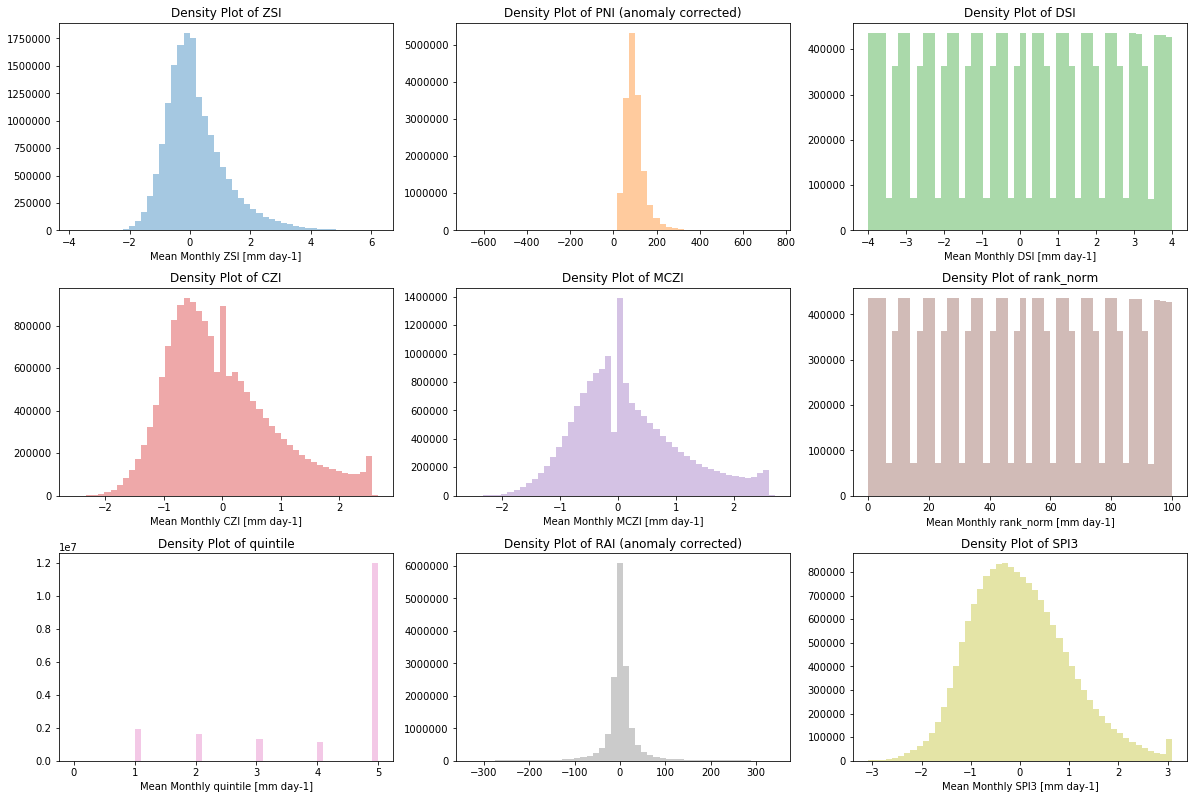

In [10]:
import itertools

if not (plot_dir / 'indexes_marginal_distribution.png').exists():
    scale = 1.4
    fig, axs = plt.subplots(3, 3, figsize=(12 * scale, 8 * scale))
    ax_ixs = list(itertools.product(range(3), repeat=2))

    for ix, index in enumerate(ds.data_vars):
        print(f"plotting {index}")
        ax_ix = ax_ixs[ix]
        ax = axs[ax_ix]
        plt.tight_layout()

        if (index != 'PNI') and (index != 'RAI'):
            plot_marginal_distribution(ds[index], color=sns.color_palette()[ix], ax=ax, summary=False, **{'kde': False})

        if index == 'PNI':
            flat = drop_nans_and_flatten(ds[index])
            flat.sort()

            # Remove values more than 10 std away from the mean
            flat = flat[~(flat < flat.mean() - (flat.std() * 10))]
            flat = flat[~(flat > flat.mean() + (flat.std() * 10))]

            sns.distplot(flat, color=sns.color_palette()[ix], ax=ax, **{'kde': False})
            ax.set_title('Density Plot of PNI (anomaly corrected 10 stds)')

        if index == 'RAI':
            flat = drop_nans_and_flatten(ds[index])
            flat.sort()

            # Remove outside of 1-99 percentiles
            flat = flat[~(flat < np.percentile(flat, q=1))]
            flat = flat[~(flat > np.percentile(flat, q=99))]

            ax.set_title('Density Plot of RAI (anomaly corrected q1-q99)')
            sns.distplot(flat, color=sns.color_palette()[ix], ax=ax, **{'kde': False})

    fig.savefig(plot_dir / 'indexes_marginal_distribution.png')
else:
    print(f"plot already exists at {plot_dir / 'indexes_marginal_distribution.png'}")

# Explore anomalies with the EventDetector

In [12]:
if not all_indices_path.parents[0].exists():
    all_indices_path.parents[0].mkdir(exist_ok=True, parents=True)

if not all_indices_path.exists():
    print(f"Saving ds to {all_indices_path.as_posix()}")
    ds.to_netcdf(all_indices_path)
else:
    print(f"Opening already saved file: {all_indices_path.name}")
    ds = xr.open_dataset(all_indices_path)
    
# open chirps precip (raw data file)
chirps = xr.open_dataset(data_path)

Opening already saved file: all_indices_kenya.nc


### Looking at SPI3

In [13]:
from src.analysis import EventDetector
import pickle

if not (analysis_path / 'spi3_eventDetector.pkl').exists():
    e = EventDetector(all_indices_path)
    e.detect(
        variable='SPI3', time_period='month', hilo='low', method='abs', value=-1
    )
    pickle.dump(e, open(analysis_path / 'spi3_eventDetector.pkl', 'wb'))
else:
    print('Loading pre-existing event detector')
    e = pickle.load(open(analysis_path / 'spi3_eventDetector.pkl', 'rb'))

Loading pre-existing event detector


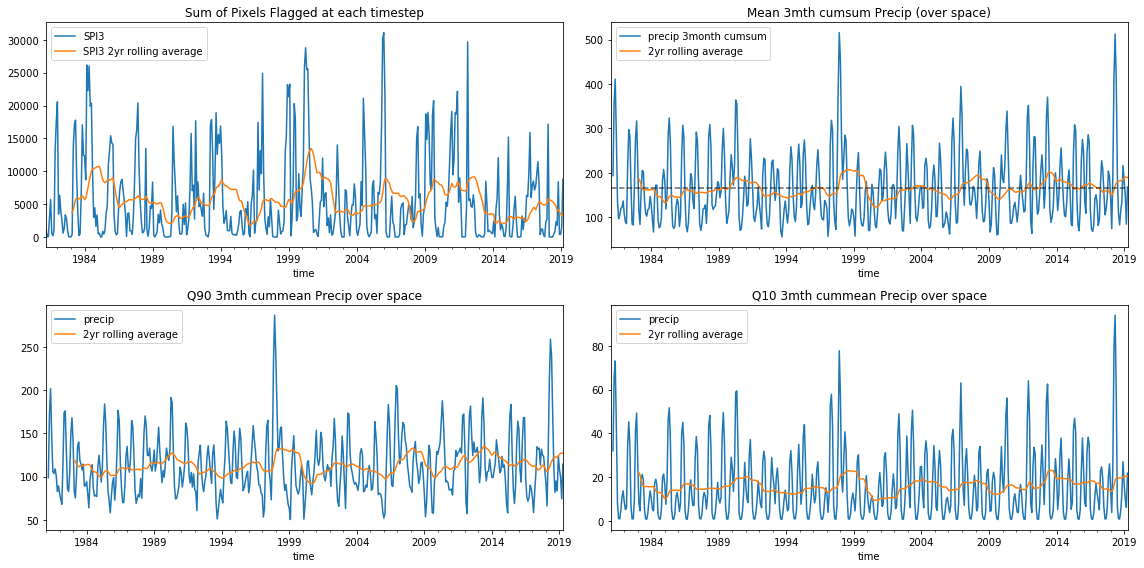

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

df = e.exceedences.sum(dim=['lat','lon']).to_dataframe()
df.plot(ax=ax[0,0])
df.rolling(window=24).mean().rename(columns={'SPI3': 'SPI3 2yr rolling average'}).plot(ax=ax[0,0])
ax[0,0].set_title('Sum of Pixels Flagged at each timestep')

df2 = chirps.rolling(time=3).sum(dim=['lat', 'lon']).mean(dim=['lat', 'lon']).to_dataframe()
df2.rename(columns={'precip': 'precip 3month cumsum'}).plot(ax=ax[0,1])
df2.rolling(window=24).mean().rename(columns={'precip': '2yr rolling average'}).plot(ax=ax[0,1])
ax[0,1].axhline(df2.mean().values, color='k', ls='--', alpha=0.6)
ax[0,1].set_title('Mean 3mth cumsum Precip (over space)');

df3 = chirps.rolling(time=3).mean(dim=['lat', 'lon']).quantile(dim=['lat', 'lon'], q=0.9).drop('quantile').to_dataframe()
df3.plot(ax=ax[1,0])
df3.rolling(window=24).mean().rename(columns={'precip': '2yr rolling average'}).plot(ax=ax[1,0])
ax[1,0].set_title('Q90 3mth cummean Precip over space')

df4 = chirps.rolling(time=3).mean(dim=['lat', 'lon']).quantile(dim=['lat', 'lon'], q=0.1).drop('quantile').to_dataframe()
df4.plot(ax=ax[1,1])
df4.rolling(window=24).mean().rename(columns={'precip': '2yr rolling average'}).plot(ax=ax[1,1])
ax[1,1].set_title('Q10 3mth cummean Precip over space')

plt.tight_layout()

# Consecutive exceedences

In [21]:
runs = e.calculate_runs()

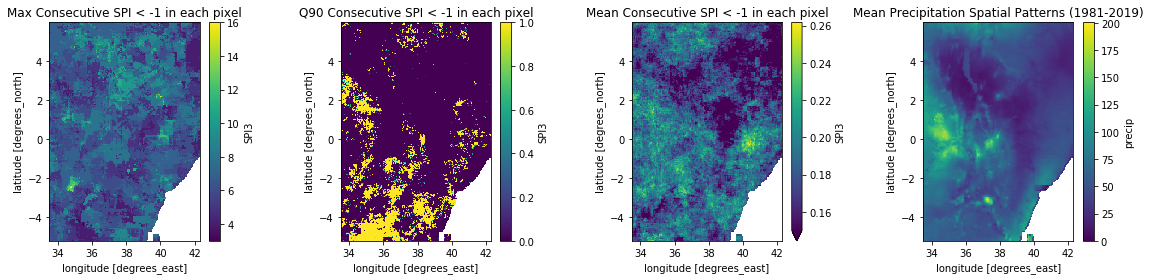

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

runs.max(dim=['time']).plot(ax=axs[0])
axs[0].set_title('Max Consecutive SPI < -1 in each pixel')

runs.quantile(dim=['time'], q=0.9).plot(ax=axs[1])
axs[1].set_title('Q90 Consecutive SPI < -1 in each pixel')

runs.mean(dim=['time']).plot(ax=axs[2], vmin=0.15)
axs[2].set_title('Mean Consecutive SPI < -1 in each pixel')

chirps.mean(dim='time').precip.plot(ax=axs[3], vmin=0)
axs[3].set_title('Mean Precipitation Spatial Patterns (1981-2019)');

plt.tight_layout();

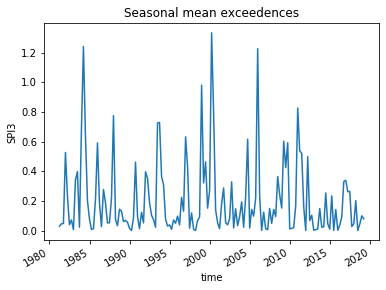

In [33]:
fig, ax = plt.subplots()
runs.resample(time='Q-DEC').mean().plot(ax=ax)
ax.set_title('Seasonal mean exceedences');

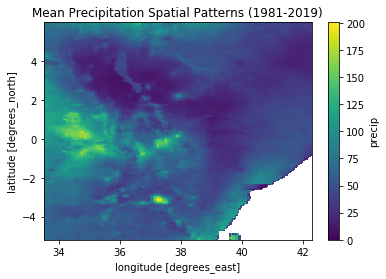

In [34]:
fig, ax = plt.subplots()
chirps.mean(dim='time').precip.plot(ax=ax, vmin=0)
ax.set_title('Mean Precipitation Spatial Patterns (1981-2019)');